**DCGAN**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import os


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
batch_size = 32

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),   # map to [-1, 1]
])

dataset = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 26.4M/26.4M [00:00<00:00, 115MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.92MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 58.7MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.3MB/s]


In [4]:
class Generator(nn.Module):
    def __init__(self, nz=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nz, 7 * 7 * 128),
            nn.SELU(inplace=True),
            nn.Unflatten(1, (128, 7, 7)),

            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2, output_padding=1),
            nn.SELU(inplace=True),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(64, 1, 5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)


In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [6]:
nz = 100  # noise dimension

G = Generator(nz).to(device)
D = Discriminator().to(device)


In [7]:
criterion = nn.BCELoss()

optimizerG = optim.Adam(G.parameters(), lr=2e-4)
optimizerD = optim.Adam(D.parameters(), lr=2e-4)


In [8]:
def save_images(epoch, fixed_noise):
    with torch.no_grad():
        fake = G(fixed_noise).detach().cpu()
    grid = vutils.make_grid(fake, nrow=5, padding=2, normalize=True)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")

    os.makedirs("images", exist_ok=True)
    plt.savefig(f"images/epoch_{epoch:04d}.png")
    plt.close()


In [9]:
epochs = 10
fixed_noise = torch.randn(25, nz, device=device)

for epoch in range(epochs):
    for real, _ in dataloader:
        real = real.to(device)
        b_size = real.size(0)
        #  Train Discriminator
        D.zero_grad()

        # Real images
        labels_real = torch.ones(b_size, 1, device=device)
        output_real = D(real)
        loss_real = criterion(output_real, labels_real)

        # Fake images
        noise = torch.randn(b_size, nz, device=device)
        fake = G(noise)
        labels_fake = torch.zeros(b_size, 1, device=device)
        output_fake = D(fake.detach())
        loss_fake = criterion(output_fake, labels_fake)

        # Combined loss
        lossD = loss_real + loss_fake
        lossD.backward()
        optimizerD.step()
        #  Train Generator
        G.zero_grad()
        output = D(fake)
        lossG = criterion(output, labels_real)  # want D(fake) to be 1
        lossG.backward()
        optimizerG.step()

    print(f"Epoch {epoch+1}/{epochs} | Loss_D: {lossD:.4f} | Loss_G: {lossG:.4f}")

    save_images(epoch+1, fixed_noise)


Epoch 1/10 | Loss_D: 0.7308 | Loss_G: 1.5054
Epoch 2/10 | Loss_D: 0.2624 | Loss_G: 3.1036
Epoch 3/10 | Loss_D: 0.4202 | Loss_G: 2.5293
Epoch 4/10 | Loss_D: 0.4297 | Loss_G: 2.8225
Epoch 5/10 | Loss_D: 0.5170 | Loss_G: 2.8127
Epoch 6/10 | Loss_D: 0.7283 | Loss_G: 2.4085
Epoch 7/10 | Loss_D: 0.9821 | Loss_G: 1.4224
Epoch 8/10 | Loss_D: 0.6352 | Loss_G: 1.8650
Epoch 9/10 | Loss_D: 0.7010 | Loss_G: 1.9130
Epoch 10/10 | Loss_D: 1.1576 | Loss_G: 1.6084


/tmp/ipython-input-1883023412.py:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipython-input-1883023412.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filenames[-1])


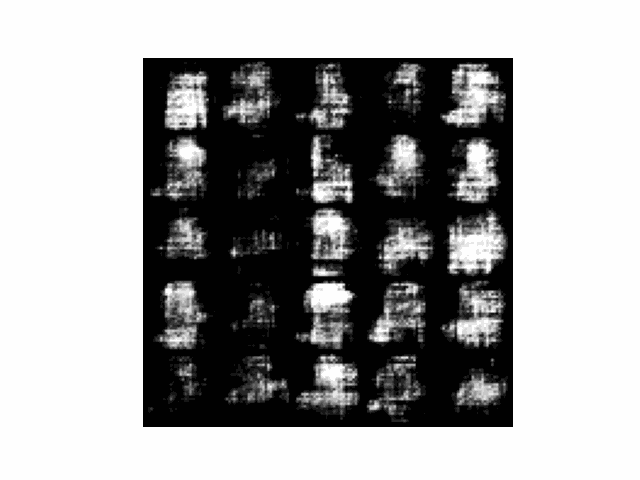

In [10]:
# import imageio
# import glob
# from IPython import display
# import os

# # folder where images were saved
# image_folder = "/content/images"
# anim_file = '/content/dcgan_results.gif'

# # get list of PNG files in correct order
# filenames = sorted(glob.glob(os.path.join(image_folder, "epoch_*.png")))

# with imageio.get_writer(anim_file, mode='I') as writer:
#     last = -1
#     for i, filename in enumerate(filenames):
#         # repeat frames to slow down animation if needed
#         frame = 2 * i
#         if round(frame) > round(last):
#             last = frame
#         else:
#             continue
#         image = imageio.imread(filename)
#         writer.append_data(image)

#     # append last frame again
#     image = imageio.imread(filenames[-1])
#     writer.append_data(image)

# display.Image(filename=anim_file)
